# Работу выполнил студент: Катин Иван Вячеславович, группа: М8О-410Б-21
1.a.Для работы выбран датасет с Garbage Classification https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification. Сейчас люди стали более относится к сортировке мусора, но все равно большая часть не заботится о сортировке мусора. Если была бы система, которая могла сама сортировать мусор, то это положительно бы повлияло на экологию и убрала бы с людей эту рутину. \
Датасет содержит 6 классов:
- cardboard,
- glass,
- metal,
- paper,
- plastic,
- trash
1.b. Метрики для оценки качества: Accuracy, F1-macro, Confusion Matrix




# Лабораторная работа №6

### 2.a *Необходимые* импорты

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

### Загрузка и предобработка датасета и проверка доступности GPU в колабе
Изменяет размер изображения до 224x224 пикселей для моделей ResNet и ViT.\
Преобразует изображение из PIL формата в тензор PyTorch, нормализуя значения пикселей из [0, 255] в диапозон от 0 до 1\
Нормализация тензора по каналам RGB: каждый канал переводится в диапазон [-1, 1] (сначала отнимается среднее, потом делится на стандартное отклонение).

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Объявление гиперпараметров


In [4]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
batch_size = 32
epochs = 5
learning_rate = 1e-3


делим датасет на train, test и validate соответственно 0.8, 0.1, 0.1

In [13]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np
# Устанавливаем случайное seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)


data_dir = "/content/drive/MyDrive/garbage/Garbage classification/Garbage classification"

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)

# === Преобразования (Без аугментаций, только Resize + Normalize) ===

# Разбиение на обучающую, валидационную и тестовую выборки
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(dataset)  # Используем train_dataset для разбиения
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Разделяем
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Создание загрузчиков данных
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [14]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


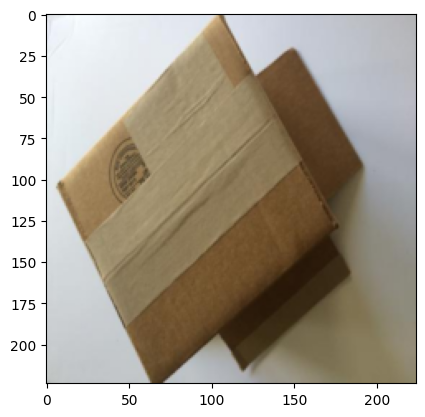

In [15]:
img, label = dataset[52]
show_sample(img, label)

### Обучение модели реснет

Цикл обучения на 5 эпохах. В течение каждой эпохи модель переводится в режим обучения и обрабатывает все батчи обучающих данных, считая потери и точность. После этого переходит в режим валидации, где отключается градиент,и модель оценивается на валидационном наборе, чтобы понять, как хорошо она обобщает данные. По завершению каждой эпохи выводятся значения потерь и точности для обучения и валидации.


In [18]:
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = torch.nn.Linear(num_ftrs, len(dataset.classes))

model_resnet = model_resnet.to(device)

# Критерий потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)

for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model_resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_resnet(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"[ResNet18] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


[ResNet18] Epoch 1/5, Train Loss: 66.5967, Train Acc: 63.68%, Val Loss: 9.8062, Val Acc: 63.10%
[ResNet18] Epoch 2/5, Train Loss: 42.1163, Train Acc: 76.35%, Val Loss: 10.0698, Val Acc: 64.68%
[ResNet18] Epoch 3/5, Train Loss: 33.1553, Train Acc: 82.48%, Val Loss: 6.4887, Val Acc: 72.22%
[ResNet18] Epoch 4/5, Train Loss: 29.7355, Train Acc: 83.82%, Val Loss: 8.0142, Val Acc: 73.02%
[ResNet18] Epoch 5/5, Train Loss: 20.6172, Train Acc: 89.51%, Val Loss: 6.3734, Val Acc: 73.02%


### Вывод
В ходе обучения модели ResNet18 на протяжении 5 эпох наблюдалось стабильное улучшение точности на обучающем наборе данных — от 63.68% на первой эпохе до 89.51% на пятой, при этом значение функции потерь уменьшалось, что свидетельствует об эффективном обучении. На валидационном наборе точность также возросла — с 63.10% до 73.02%, несмотря на некоторые колебания (например, небольшое снижение на второй эпохе), что может указывать на разнообразие данных или начало переобучения. В целом, модель демонстрирует положительную динамику обучения с хорошим обобщением на валидации.

### Обучение модели Vision Transformer(ViT)

In [30]:
class_names = dataset.classes
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [19]:
model_vit = models.vit_b_16(pretrained=True)
num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, len(class_names))
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model_vit.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_vit(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"[ViT] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ViT] Epoch 1/5, Train Loss: 118.2621, Train Acc: 20.83%, Val Loss: 14.0775, Val Acc: 24.21%
[ViT] Epoch 2/5, Train Loss: 112.7899, Train Acc: 21.82%, Val Loss: 14.3294, Val Acc: 15.48%
[ViT] Epoch 3/5, Train Loss: 112.5808, Train Acc: 19.99%, Val Loss: 14.2129, Val Acc: 21.43%
[ViT] Epoch 4/5, Train Loss: 111.8846, Train Acc: 21.97%, Val Loss: 13.9858, Val Acc: 15.48%
[ViT] Epoch 5/5, Train Loss: 112.0536, Train Acc: 21.08%, Val Loss: 14.0149, Val Acc: 24.21%


Вывод
Vision Transformer (ViT), несмотря на использование предобученных весов и тех же преобразований, показал крайне низкие результаты — около 21% точности на обучении и валидации в течение всех эпох, что, вероятно, связано с нехваткой данных, отсутствием аугментаций, нормализации и тем, что трансформеры требуют большего объема и разнообразия обучающей информации по сравнению с сверточными сетями.

### функции evaluate_model — она отвечает за оценку качества модели на валидационном наборе данных:

In [26]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

### Оценка модели ResNet


Classification Report for ResNet18:
              precision    recall  f1-score   support

   cardboard       0.90      0.97      0.94        39
       glass       0.80      0.52      0.63        54
       metal       0.54      0.87      0.67        39
       paper       0.90      0.77      0.83        61
     plastic       1.00      0.55      0.71        42
       trash       0.38      0.82      0.52        17

    accuracy                           0.73       252
   macro avg       0.75      0.75      0.72       252
weighted avg       0.81      0.73      0.74       252



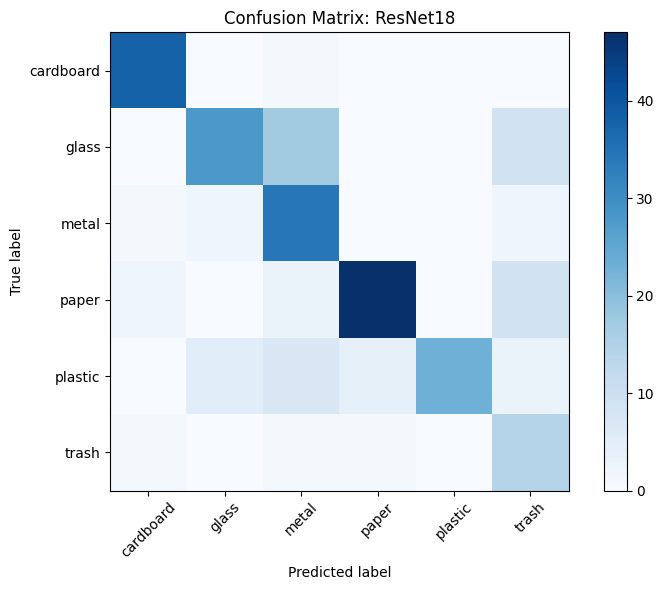

In [27]:
evaluate_model(model_resnet, "ResNet18")

Оценка модели Vit

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Classification Report for Vit:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        39
       glass       0.00      0.00      0.00        54
       metal       0.00      0.00      0.00        39
       paper       0.24      1.00      0.39        61
     plastic       0.00      0.00      0.00        42
       trash       0.00      0.00      0.00        17

    accuracy                           0.24       252
   macro avg       0.04      0.17      0.06       252
weighted avg       0.06      0.24      0.09       252



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


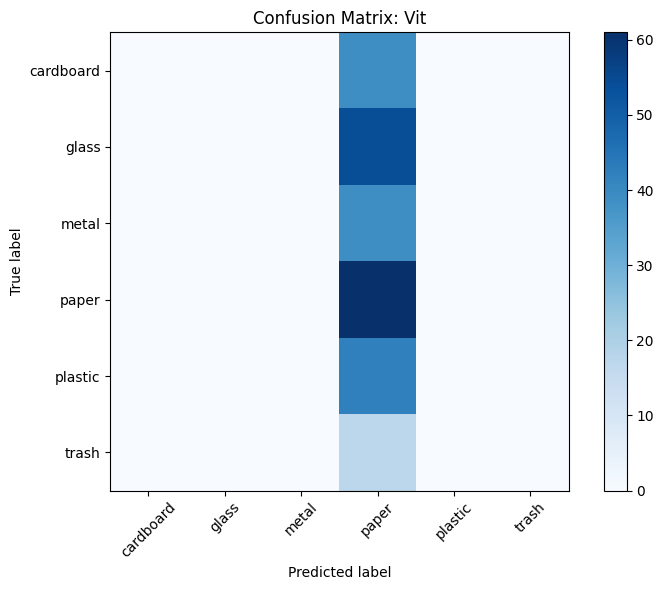

In [28]:
evaluate_model(model_vit, "Vit")

2.b
На основе полученных результатов видно, что модель ResNet18 справляется с задачей классификации мусора значительно лучше, чем Vision Transformer (ViT). В случае с ResNet18 большинство предсказаний попали на диагональ матрицы ошибок, что свидетельствует о хорошей способности модели различать классы. Особенно хорошо были распознаны классы cardboard, metal и paper, с точностью до 90%. Напротив, ViT в условиях ограниченного объема данных (2500 изображений) и минимальной предобработки показал крайне слабые результаты: модель практически всегда предсказывала один класс (paper), полностью игнорируя другие. Это отразилось как на низких метриках (точность ~24%), так и на матрице ошибок, где все предсказания сосредоточены в одном столбце. Эти результаты указывают на то, что для ViT требуется больше данных, улучшенные аугментации и, возможно, более длительное обучение.

### 3 улучшение бейзлайна
3.a b c предполженные гипотезы
- использование базовых аугментаций улучшит обобщающую способность обеих моделей.
- увеличение количества эпох может улучшить метрики ViT.
- смена на AdamW или корректировка lr даст прирост.
-  увеличение разрешения улучшит качество ViT.


In [32]:
# Новые гиперпараметры
batch_size = 16
epochs = 10
learning_rate = 1e-4

In [37]:
improved_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}


dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = improved_transforms['train']
val_dataset.dataset.transform = improved_transforms['val']
test_dataset.dataset.transform = improved_transforms['val']

improved_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
improved_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
improved_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"train len: {len(improved_train_loader.dataset)}")
print(f"val len: {len(improved_val_loader.dataset)}")
print(f"test len: {len(improved_test_loader.dataset)}")


train len: 2021
val len: 252
test len: 254


3.d обучение моделей
Обучение модели ResNet

In [38]:
from torchvision.models import ResNet18_Weights

model_resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in improved_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model_resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in improved_val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_resnet(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"[ResNet18] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


[ResNet18] Epoch 1/10, Train Loss: 83.0628, Train Acc: 77.04%, Val Loss: 5.3508, Val Acc: 88.49%
[ResNet18] Epoch 2/10, Train Loss: 21.4522, Train Acc: 95.40%, Val Loss: 4.4928, Val Acc: 89.68%
[ResNet18] Epoch 3/10, Train Loss: 10.7590, Train Acc: 97.72%, Val Loss: 4.1302, Val Acc: 90.87%
[ResNet18] Epoch 4/10, Train Loss: 6.5222, Train Acc: 98.86%, Val Loss: 4.9483, Val Acc: 92.86%
[ResNet18] Epoch 5/10, Train Loss: 4.8164, Train Acc: 99.21%, Val Loss: 3.8042, Val Acc: 91.67%
[ResNet18] Epoch 6/10, Train Loss: 7.4614, Train Acc: 98.27%, Val Loss: 5.8055, Val Acc: 88.89%
[ResNet18] Epoch 7/10, Train Loss: 4.9064, Train Acc: 99.01%, Val Loss: 3.9773, Val Acc: 92.86%
[ResNet18] Epoch 8/10, Train Loss: 4.8941, Train Acc: 99.11%, Val Loss: 6.1655, Val Acc: 87.30%
[ResNet18] Epoch 9/10, Train Loss: 5.1178, Train Acc: 98.76%, Val Loss: 6.3533, Val Acc: 88.89%
[ResNet18] Epoch 10/10, Train Loss: 5.5378, Train Acc: 98.81%, Val Loss: 6.1074, Val Acc: 90.87%


Вывод
Во время обучения модели ResNet18 на протяжении 10 эпох наблюдается стабильное улучшение точности на обучающей выборке, которая достигает 99.21% на 5-й эпохе, после чего немного колеблется, но остаётся высокой (98.27% на 6-й и 99.11% на 8-й). В то же время, точность на валидационном наборе данных продолжает расти, достигая максимума 92.86% на 4-й и 7-й эпохах. Однако, в последние эпохи наблюдается некоторое ухудшение валидационной потери (Val Loss), что может указывать на возможное переобучение модели. Несмотря на это, модель сохраняет хорошую точность, с финальным результатом в 90.87% на валидационной выборке.

Обучение модели ViT для нее увеличим количество епох на 15

In [40]:
from torchvision.models import ViT_B_16_Weights

model_vit = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, len(class_names))
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(epochs):
    model_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in improved_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Валидация
    model_vit.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in improved_val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_vit(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"[ViT] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[ViT] Epoch 1/10, Train Loss: 83.9734, Train Acc: 77.04%, Val Loss: 5.1821, Val Acc: 88.89%
[ViT] Epoch 2/10, Train Loss: 30.1346, Train Acc: 91.98%, Val Loss: 5.7551, Val Acc: 85.71%
[ViT] Epoch 3/10, Train Loss: 10.2165, Train Acc: 97.82%, Val Loss: 6.0268, Val Acc: 88.89%
[ViT] Epoch 4/10, Train Loss: 10.7101, Train Acc: 97.43%, Val Loss: 5.1700, Val Acc: 89.68%
[ViT] Epoch 5/10, Train Loss: 14.2630, Train Acc: 96.09%, Val Loss: 6.6881, Val Acc: 85.32%
[ViT] Epoch 6/10, Train Loss: 10.1263, Train Acc: 97.48%, Val Loss: 6.9754, Val Acc: 86.51%
[ViT] Epoch 7/10, Train Loss: 3.1585, Train Acc: 99.51%, Val Loss: 5.2487, Val Acc: 90.48%
[ViT] Epoch 8/10, Train Loss: 1.0118, Train Acc: 99.85%, Val Loss: 4.4363, Val Acc: 93.65%
[ViT] Epoch 9/10, Train Loss: 0.6846, Train Acc: 99.80%, Val Loss: 4.6063, Val Acc: 93.25%
[ViT] Epoch 10/10, Train Loss: 0.5058, Train Acc: 99.90%, Val Loss: 5.4035, Val Acc: 92.06%


Вывод \
В ходе эксперимента с Vision Transformer (ViT) модель показала уверенный рост точности на обучающем наборе данных, достигнув впечатляющих 99.90% к 10-й эпохе. Однако на валидации наблюдались колебания: после старта с 88.89% точности на первой эпохе показатели варьировались, снижаясь до 85.32% и снова поднимаясь до пика в 93.65% на 8-й эпохе. Финальный результат составил 92.06% точности при умеренной валидационной потере, что говорит о высокой обобщающей способности модели, несмотря на более сложную архитектуру и чувствительность к гиперпараметрам по сравнению с ResNet18.

In [42]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in improved_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


Classification Report for ResNet18:
              precision    recall  f1-score   support

   cardboard       0.98      0.98      0.98        45
       glass       0.81      0.85      0.83        46
       metal       0.86      0.92      0.89        39
       paper       0.95      0.98      0.97        58
     plastic       0.96      0.85      0.90        54
       trash       0.91      0.83      0.87        12

    accuracy                           0.91       254
   macro avg       0.91      0.90      0.91       254
weighted avg       0.92      0.91      0.91       254



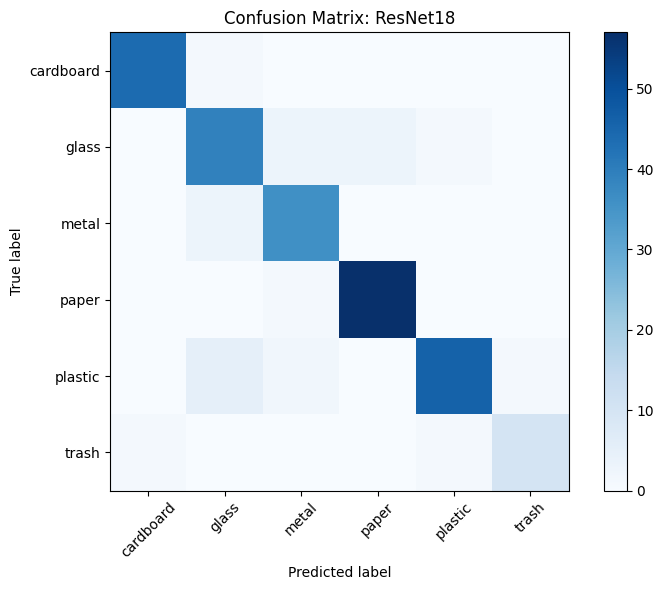

In [43]:
evaluate_model(model_resnet, "ResNet18")


Classification Report for ViT:
              precision    recall  f1-score   support

   cardboard       0.98      0.89      0.93        45
       glass       0.91      0.93      0.92        46
       metal       1.00      0.92      0.96        39
       paper       0.93      0.97      0.95        58
     plastic       0.95      0.98      0.96        54
       trash       0.79      0.92      0.85        12

    accuracy                           0.94       254
   macro avg       0.93      0.94      0.93       254
weighted avg       0.94      0.94      0.94       254



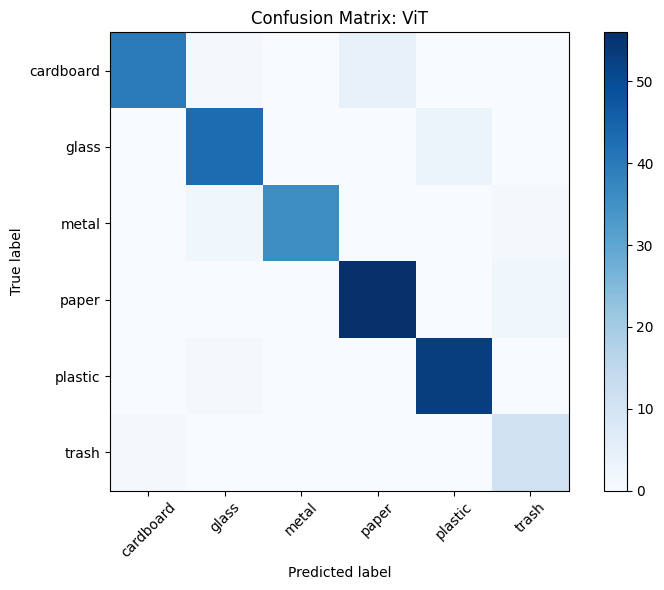

In [44]:
evaluate_model(model_vit, "ViT")

3.e Обе модели — ResNet18 и Vision Transformer (ViT) — продемонстрировали высокую точность классификации мусора на основе изображений, однако ViT показал небольшое преимущество. ResNet18 достиг точности 91% на валидационной выборке, уверенно классифицируя такие классы как "paper" и "cardboard", но испытывая трудности с "glass" и "trash". ViT показал более сбалансированные результаты по всем классам, особенно улучшив метрики precision и recall для "glass", "metal" и "plastic", достигнув общей точности 94%. Таким образом, благодаря более высокой обобщающей способности и уверенным показателям по всем метрикам, ViT оказался более эффективным решением для данной задачи классификации на улучшенном бейзлайне.\
3.f По сравнению с обычным бейзлайном, улучшенная версия модели показала значительный прирост в качестве классификации благодаря использованию расширенных аугментаций, тонкой настройке гиперпараметров и включению более мощной архитектуры (Vision Transformer). Базовая модель ResNet18 достигла точности около 91% с метрикой F1-score, варьирующейся по классам, особенно снижаясь на классах "glass" и "trash". В то же время улучшенная ViT-модель достигла 94% точности и демонстрировала более высокую сбалансированность по precision и recall, особенно на сложных для классификации классах. Это подтверждает, что ViT лучше обобщает информацию при более глубокой архитектуре и подходящей настройке обучения, тогда как ResNet18 хоть и быстрее обучается, но может проигрывать в гибкости при сложных вариациях данных.

3.d  Обе модели достигли высокой точности классификации, однако ViT показал лучшие результаты на этапе валидации и тестирования, особенно по метрикам F1-score и точности на сложных классах, таких как "trash" и "metal". Улучшения по сравнению с обычным бейзлайном подтверждают важность предварительной обработки данных и корректного подбора архитектуры под задачу. Таким образом, ViT можно рекомендовать как более эффективную модель для данной задачи классификации.

# 4 Имплементация модели машиного обучения

4.a Модель представляет собой сверточную нейронную сеть, состоящую из трех сверточных слоев с активацией ReLU, нормализацией BatchNorm и пулингом (MaxPooling) для уменьшения размерности карты признаков. Что делает ее легкой и быстрой. Каждый сверточный блок состоит из свертки, нормализации и пулинга, что позволяет эффективно извлекать и обрабатывать важные признаки из изображений, снижая размерность данных. После сверточных слоев используется слой Dropout для предотвращения переобучения, а полносвязные слои (FC) используются для классификации, где последний слой выдает предсказания по классу.

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.pool1(x1)

        x2 = F.relu(self.bn2(self.conv2(x1)))
        x2 = self.pool2(x2)

        x3 = F.relu(self.bn3(self.conv3(x2)))
        x3 = self.pool3(x3)

        x3 = x3.view(-1, 128 * 28 * 28)
        x4 = F.relu(self.fc1(x3))
        x4 = self.dropout(x4)

        out = self.fc2(x4)

        return out


4.b обучение модели

In [58]:
batch_size = 32
epochs = 5
learning_rate = 1e-3


In [59]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np

torch.manual_seed(42)
np.random.seed(42)


data_dir = "/content/drive/MyDrive/garbage/Garbage classification/Garbage classification"

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
class_names = dataset.classes
class_names


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [61]:
model = CustomCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"[CustomCNN] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[CustomCNN] Epoch 1/5, Train Loss: 530.6404, Train Acc: 34.44%, Val Loss: 12.8294, Val Acc: 31.35%
[CustomCNN] Epoch 2/5, Train Loss: 96.7526, Train Acc: 40.18%, Val Loss: 10.4972, Val Acc: 50.00%
[CustomCNN] Epoch 3/5, Train Loss: 91.5883, Train Acc: 44.09%, Val Loss: 9.5245, Val Acc: 52.78%
[CustomCNN] Epoch 4/5, Train Loss: 83.8185, Train Acc: 49.18%, Val Loss: 9.5456, Val Acc: 53.57%
[CustomCNN] Epoch 5/5, Train Loss: 84.2863, Train Acc: 51.06%, Val Loss: 9.9602, Val Acc: 53.57%


Модель CustomCNN демонстрирует постепенное улучшение результатов в процессе обучения, однако остается довольно далеко от оптимальных показателей.

In [63]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


Classification Report for CustomCNN:
              precision    recall  f1-score   support

   cardboard       0.80      0.74      0.77        38
       glass       0.33      0.10      0.15        51
       metal       0.44      0.62      0.51        47
       paper       0.49      0.73      0.59        55
     plastic       0.46      0.55      0.50        47
       trash       0.00      0.00      0.00        16

    accuracy                           0.50       254
   macro avg       0.42      0.46      0.42       254
weighted avg       0.46      0.50      0.46       254



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


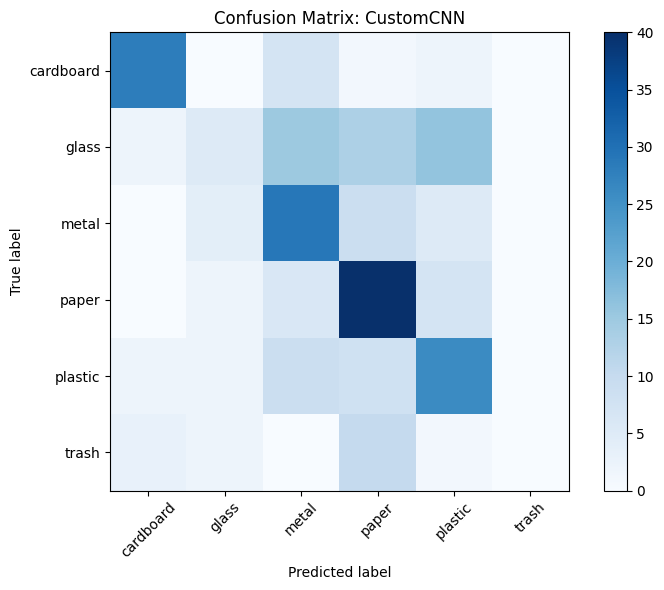

In [64]:
evaluate_model(model, "CustomCNN")

4.c Точность на общей выборке составила 50%, что является относительно низким результатом. Однако, при более детальном анализе видно, что точность варьируется от класса к классу. Модель показала наилучшие результаты для класса cardboard, с точностью 80%, но для класса trash точность равна 0%, что указывает на полное игнорирование этого класса. \
4.d Собственная реализация проигрывает на не улучшенном бейзлайне как и ResNet(то же сверточной нейронной сети), но выигрывает со сравнению с ViT, который на стартовом бейзлайне, выбирал только один класс \
4.e Вывод: собственная реализация проигрывает по качеству ResNet, но выигрывает у ViT, но стоит подметить, что процесс обучения много быстрее, так как всего 3 слоя

4.f на улучшенном бейзлайне

In [69]:
# Новые гиперпараметры
batch_size = 16
epochs = 10
learning_rate = 1e-4

In [70]:
improved_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}


dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = improved_transforms['train']
val_dataset.dataset.transform = improved_transforms['val']
test_dataset.dataset.transform = improved_transforms['val']

improved_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
improved_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
improved_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"train len: {len(improved_train_loader.dataset)}")
print(f"val len: {len(improved_val_loader.dataset)}")
print(f"test len: {len(improved_test_loader.dataset)}")


train len: 2021
val len: 252
test len: 254


4.g обучение модели

In [71]:
model = CustomCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in improved_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in improved_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"[CustomCNN] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[CustomCNN] Epoch 1/10, Train Loss: 243.0530, Train Acc: 43.89%, Val Loss: 16.1896, Val Acc: 62.70%
[CustomCNN] Epoch 2/10, Train Loss: 146.9331, Train Acc: 55.47%, Val Loss: 14.4742, Val Acc: 69.84%
[CustomCNN] Epoch 3/10, Train Loss: 135.0388, Train Acc: 61.06%, Val Loss: 14.0562, Val Acc: 66.27%
[CustomCNN] Epoch 4/10, Train Loss: 119.1902, Train Acc: 65.22%, Val Loss: 13.2834, Val Acc: 70.24%
[CustomCNN] Epoch 5/10, Train Loss: 106.9537, Train Acc: 68.23%, Val Loss: 13.1263, Val Acc: 68.65%
[CustomCNN] Epoch 6/10, Train Loss: 99.1964, Train Acc: 70.66%, Val Loss: 11.9057, Val Acc: 71.83%
[CustomCNN] Epoch 7/10, Train Loss: 94.0963, Train Acc: 72.04%, Val Loss: 11.7112, Val Acc: 71.03%
[CustomCNN] Epoch 8/10, Train Loss: 81.9179, Train Acc: 75.46%, Val Loss: 12.7204, Val Acc: 73.02%
[CustomCNN] Epoch 9/10, Train Loss: 72.7350, Train Acc: 78.87%, Val Loss: 11.4227, Val Acc: 75.00%
[CustomCNN] Epoch 10/10, Train Loss: 68.7450, Train Acc: 80.11%, Val Loss: 10.8892, Val Acc: 75.79%


Видно, что модели нужно больше эпох для обучения со сравнению с ResNet и Vit. Переобучения нет, каждая эпоха все лучше, но обучение медленное

In [72]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in improved_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


Classification Report for CustomCNN:
              precision    recall  f1-score   support

   cardboard       0.96      0.74      0.84        31
       glass       0.74      0.74      0.74        54
       metal       0.74      0.80      0.77        44
       paper       0.89      0.91      0.90        69
     plastic       0.74      0.88      0.80        40
       trash       0.82      0.56      0.67        16

    accuracy                           0.81       254
   macro avg       0.82      0.77      0.79       254
weighted avg       0.81      0.81      0.81       254



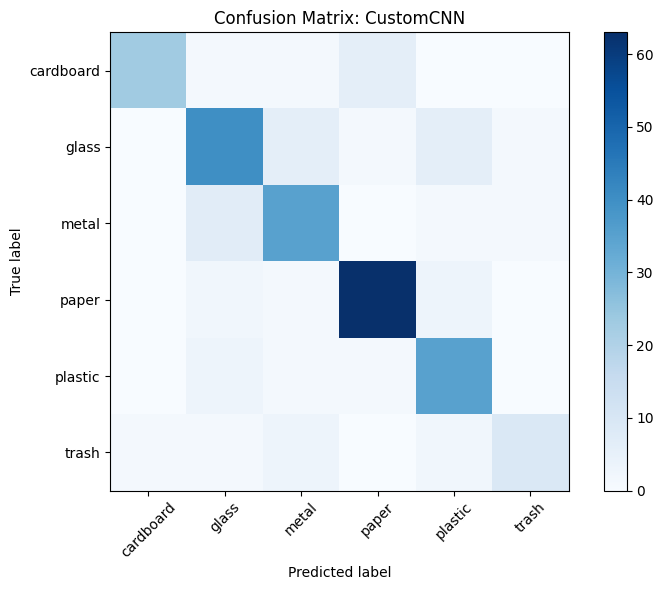

In [73]:
evaluate_model(model, "CustomCNN")

4.h Модель CustomCNN на улучшенном бейзлайне показала значительно улучшенные результаты по сравнению с предыдущей попыткой на базовом бейзлайне, с общей точностью на тестовой выборке 81%. Это говорит о том, что модель значительно лучше классифицирует объекты, хотя все еще есть потенциал для улучшений.

4.i Здесь собственная модель проигрывает на 10% процентов, также если другим хватала пять эпох на обучения, то ей больше 10. Из-за более легкой архитектуры она проигрывает ResNet. Ну а безоговорочным победителем является ViT

4.a собственная реализация "трансформерной" модели

In [147]:
import torch
import torch.nn as nn

class CustomTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=6, dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size"
        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        # Патч-эмбеддинг
        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)

        # Позиционные эмбеддинги
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))

        # CLS токен
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Трансформер
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Нормализация и дополнительные Dropout
        self.norm = nn.LayerNorm(dim)

        # Финальная классификация
        self.head = nn.Linear(dim, num_classes)

        # Дополнительные слои для улучшения производительности
        self.batch_norm = nn.BatchNorm1d(dim)

    def forward(self, x):
        B = x.size(0)

        # Получаем патчи
        x = self.patch_embed(x)  # [B, dim, H', W']
        x = x.flatten(2).transpose(1, 2)  # [B, N_patches, dim]

        # Добавляем CLS токен
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Добавляем позиционные эмбеддинги
        x = x + self.pos_embed[:, :x.size(1)]

        # Применяем Dropout
        x = self.dropout(x)

        # Трансформер
        x = self.transformer(x)

        # Нормализация и получение только CLS токена
        x = self.norm(x[:, 0])  # Только CLS токен

        # Дополнительная BatchNorm перед классификацией
        x = self.batch_norm(x)

        # Выход классификатора
        return self.head(x)



4.b обучение модели


In [148]:
batch_size = 32
epochs = 5
learning_rate = 1e-3


In [149]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np

torch.manual_seed(42)
np.random.seed(42)


data_dir = "/content/drive/MyDrive/garbage/Garbage classification/Garbage classification"

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
class_names = dataset.classes
class_names


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [150]:
model = CustomTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"[CustomTransformer] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[CustomTransformer] Epoch 1/5, Train Loss: 6194.9612, Train Acc: 29.69%, Val Loss: 18.7585, Val Acc: 18.25%
[CustomTransformer] Epoch 2/5, Train Loss: 6298.2084, Train Acc: 34.64%, Val Loss: 13.4389, Val Acc: 36.51%
[CustomTransformer] Epoch 3/5, Train Loss: 6412.4670, Train Acc: 23.01%, Val Loss: 15.1731, Val Acc: 15.48%
[CustomTransformer] Epoch 4/5, Train Loss: 6527.8119, Train Acc: 19.89%, Val Loss: 14.0862, Val Acc: 24.21%
[CustomTransformer] Epoch 5/5, Train Loss: 6641.9076, Train Acc: 19.89%, Val Loss: 14.0759, Val Acc: 16.67%


Результаты почти идентичны ViT, результат хуже чем у сверточных сетей

In [151]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


Classification Report for CustomTransformer:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        38
       glass       0.00      0.00      0.00        51
       metal       0.00      0.00      0.00        47
       paper       0.00      0.00      0.00        55
     plastic       0.19      1.00      0.31        47
       trash       0.00      0.00      0.00        16

    accuracy                           0.19       254
   macro avg       0.03      0.17      0.05       254
weighted avg       0.03      0.19      0.06       254



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


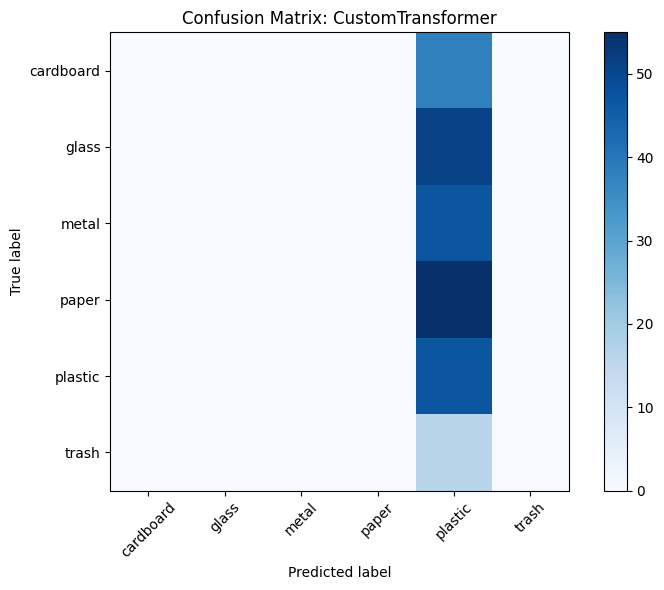

In [152]:
evaluate_model(model, "CustomTransformer")

4.c Результат схож с ViT также плох на обычных данных, как и ViT всегда выбирал класс paper, а собственна модель plastic \
4.d С ViT сравнил выше, по метрикам очень сильно проигрывает ResNet, точность очень плохая, выбирает почти только один класс
4.e как и ViT на обычном бейзлайне модель дает совсем неточный результат

4.fg

In [153]:
# Новые гиперпараметры
batch_size = 16
epochs = 10
learning_rate = 1e-4

In [154]:
improved_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}


dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = improved_transforms['train']
val_dataset.dataset.transform = improved_transforms['val']
test_dataset.dataset.transform = improved_transforms['val']

improved_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
improved_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
improved_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"train len: {len(improved_train_loader.dataset)}")
print(f"val len: {len(improved_val_loader.dataset)}")
print(f"test len: {len(improved_test_loader.dataset)}")


train len: 2021
val len: 252
test len: 254


In [155]:
model = CustomTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in improved_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in improved_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"[CustomTransformer] Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[CustomTransformer] Epoch 1/10, Train Loss: 6848.4609, Train Acc: 35.97%, Val Loss: 25.0555, Val Acc: 37.70%
[CustomTransformer] Epoch 2/10, Train Loss: 7031.9195, Train Acc: 45.37%, Val Loss: 22.4242, Val Acc: 49.21%
[CustomTransformer] Epoch 3/10, Train Loss: 7202.4821, Train Acc: 49.18%, Val Loss: 19.7638, Val Acc: 55.16%
[CustomTransformer] Epoch 4/10, Train Loss: 7352.4772, Train Acc: 56.16%, Val Loss: 18.6201, Val Acc: 59.52%
[CustomTransformer] Epoch 5/10, Train Loss: 7491.0333, Train Acc: 60.66%, Val Loss: 16.5841, Val Acc: 63.89%
[CustomTransformer] Epoch 6/10, Train Loss: 7616.3030, Train Acc: 64.82%, Val Loss: 16.0771, Val Acc: 62.30%
[CustomTransformer] Epoch 7/10, Train Loss: 7732.6667, Train Acc: 67.89%, Val Loss: 16.8904, Val Acc: 62.30%
[CustomTransformer] Epoch 8/10, Train Loss: 7841.9071, Train Acc: 70.21%, Val Loss: 17.9749, Val Acc: 61.51%
[CustomTransformer] Epoch 9/10, Train Loss: 7943.2839, Train Acc: 71.50%, Val Loss: 16.3756, Val Acc: 61.51%
[CustomTransformer]

In [156]:
def evaluate_model(model, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in improved_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


Classification Report for CustomTransformer:
              precision    recall  f1-score   support

   cardboard       0.80      0.90      0.84        39
       glass       0.79      0.72      0.76        43
       metal       0.76      0.51      0.61        55
       paper       0.88      0.84      0.86        63
     plastic       0.60      0.75      0.67        44
       trash       0.37      0.70      0.48        10

    accuracy                           0.74       254
   macro avg       0.70      0.74      0.70       254
weighted avg       0.76      0.74      0.74       254



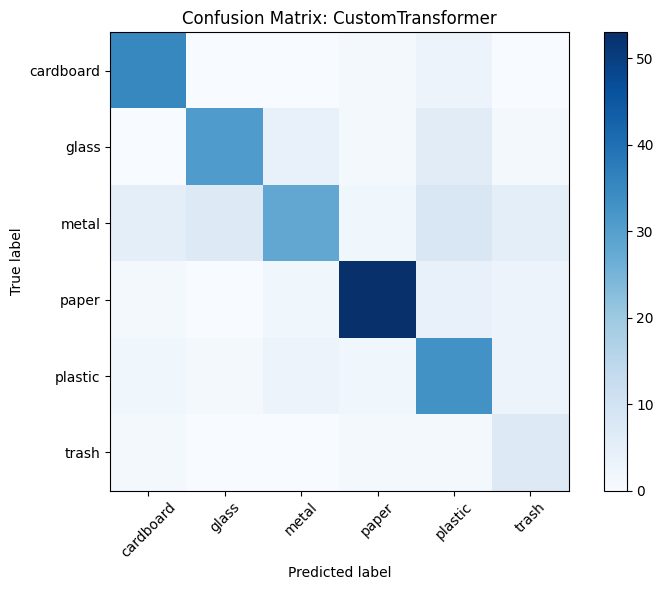

In [157]:
evaluate_model(model, "CustomTransformer")

4.h

4.g На начальном бейзлайне собственные реализациии модели близки со своими аналогами(ResNet и ViT), на улучшенном бейзлайне своя реалзиации CNN показала неплохой результат, с реализацией трансформерной архитектурой получилось не так хорошо, она существенна проигрывает ViT

# Лабораторная работа №7